In [103]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [104]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.show()
# Where to save the figures
PROJECT_ROOT_DIR = "E:\\CLASSES\\Code\\dl\\codedl08"
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [105]:
import tensorflow as tf
tf.__version__

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


'1.5.0'

## Problem 1: Manual RNN for 3 Time Steps with Inputs Created using scalars

In [106]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
X2 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)
Y2 = tf.tanh(tf.matmul(Y1, Wy) + tf.matmul(X2, Wx) + b)


init = tf.global_variables_initializer()

In [107]:
import numpy as np

X0_batch = np.array([[0, 1, 2],  [3, 4, 5], [6, 7, 8],    [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7],  [0, 0, 0], [6, 5, 4],    [3, 2, 1]]) # t = 1
X2_batch = np.array([[19,18, 17],[10, 0, 0],[16, 15, 14], [9, 8, 7]]) # t = 2

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val, Y2_val= sess.run([Y0, Y1, Y2], feed_dict={X0: X0_batch, X1: X1_batch,X2: X2_batch})

In [108]:
print(Y0_val)

[[-0.4078007  -0.99017674  0.30276212 -0.99990416 -0.9811499 ]
 [-0.98695505 -0.99999875 -0.9999973  -1.         -0.9998697 ]
 [-0.9997951  -1.         -1.         -1.         -0.9999991 ]
 [-0.98946536 -0.6468017  -1.          1.         -0.75153446]]


In [109]:
print(Y1_val)

[[-9.9999958e-01 -9.9999994e-01 -1.0000000e+00 -1.0000000e+00
  -9.9988484e-01]
 [-9.8624408e-01  9.7494888e-01 -9.8425567e-01 -9.9958420e-01
  -5.6340359e-04]
 [-9.9999201e-01 -9.9951506e-01 -1.0000000e+00 -1.0000000e+00
  -9.8999643e-01]
 [-9.8768336e-01 -9.5184243e-01 -9.9999988e-01 -9.9983954e-01
   5.3670701e-02]]


In [110]:
print(Y2_val)

[[-1.         -1.         -1.         -1.         -1.        ]
 [-0.9966389  -0.57160723 -1.          0.99999994  0.19519489]
 [-1.         -1.         -1.         -1.         -1.        ]
 [-0.9999995  -1.         -1.         -1.         -0.9997735 ]]


## Problem 1. Manual RNN for 3 Time Steps with Inputs Created using tensors

In [111]:
n_steps = 3  # new - the number of sequence steps, i.e. the length of the sequence
n_inputs = 3  # as above
n_neurons = 5  # as above
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name='X')

# transpose so that the number of steps is the first dimension of the tensor
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]), name='X_seqs')

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])
# Create a tensor for each batch of inputs
X_batch = np.array([
        # t = 0      t = 1     t=2
        [[0, 1, 2], [9, 8, 7],[19, 18, 17]], # instance 1
        [[3, 4, 5], [0, 0, 0],[10,0,0]], # instance 2
        [[6, 7, 8], [6, 5, 4],[16,15,14]], # instance 3
        [[9, 0, 1], [3, 2, 1],[9, 8, 7]], # instance 4
    ])
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

print('Outputs with n_steps first: ')
print(outputs_val)
print()
print('With the final states: ')
print(np.transpose(outputs_val, axes=[1, 0, 2])[2])

Outputs with n_steps first: 
[[[-0.4565232  -0.6806412   0.40938237  0.631045   -0.45732823]
  [-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]
  [-0.9995499  -1.          0.9994691   1.         -1.        ]]

 [[-0.80015343 -0.99218273  0.78177965  0.9971032  -0.9964609 ]
  [-0.637116    0.11300936  0.5798437   0.43105593 -0.63716984]
  [ 0.9905775  -0.9984364  -0.58464646  0.99943984 -0.9994815 ]]

 [[-0.93605185 -0.99983793  0.9308867   0.9999814  -0.99998313]
  [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]
  [-0.9984006  -1.          0.9981776   1.         -1.        ]]

 [[ 0.99273676 -0.9981933  -0.5554365   0.99890316 -0.9953323 ]
  [-0.02746332 -0.7319198   0.7827872   0.9525682  -0.9781772 ]
  [-0.96692675 -0.99993384  0.97272795  0.99999934 -0.99999976]]]

With the final states: 
[[-0.9995499  -1.          0.9994691   1.         -1.        ]
 [ 0.9905775  -0.9984364  -0.58464646  0.99943984 -0.9994815 ]
 [-0.9984006  -1.          0.9981776   1.   

In [112]:
show_graph(tf.get_default_graph())

## Problem 3 Using `dynamic_rnn()`

In [113]:
n_steps = 3
n_inputs = 3
n_neurons = 5

In [114]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [115]:
init = tf.global_variables_initializer()

In [116]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7],[19, 18, 17]], # instance 1
        [[3, 4, 5], [0, 0, 0],[10,0,0]], # instance 2
        [[6, 7, 8], [6, 5, 4],[16,15,14]], # instance 3
        [[9, 0, 1], [3, 2, 1],[9, 8, 7]], # instance 4

    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [117]:
print(outputs_val)
print()
print('With the final states: ')
print(np.transpose(outputs_val, axes=[1, 0, 2])[2])

[[[-0.46430176 -0.04473137  0.45657092 -0.60155606 -0.2879542 ]
  [-0.99999994 -0.9713097   0.99933445 -0.6387588  -0.90433717]
  [-1.         -0.99995065  1.         -0.99458724 -0.99939996]]

 [[-0.9983903  -0.7146238   0.95593154 -0.8631454  -0.6819607 ]
  [ 0.52432036  0.32354677  0.5477097   0.32016155 -0.6016544 ]
  [-0.9999861  -0.8498483   0.45853102 -0.6554884   0.10418025]]

 [[-0.9999964  -0.94119084  0.99728245 -0.95754665 -0.87851125]
  [-0.9998779  -0.88867235  0.9954021  -0.22945842 -0.9196897 ]
  [-1.         -0.99981916  0.9999994  -0.98279506 -0.99870294]]

 [[-0.99997157 -0.75314504  0.73893744 -0.9392927   0.46864882]
  [-0.968817   -0.10343017  0.84094274 -0.09726938 -0.2802728 ]
  [-0.99999994 -0.9784397   0.99925184 -0.6381149  -0.9606312 ]]]

With the final states: 
[[-1.         -0.99995065  1.         -0.99458724 -0.99939996]
 [-0.9999861  -0.8498483   0.45853102 -0.6554884   0.10418025]
 [-1.         -0.99981916  0.9999994  -0.98279506 -0.99870294]
 [-0.99999

In [118]:
show_graph(tf.get_default_graph())

# Problem 3: Time series

In [119]:
t_min, t_max = 0, 30
resolution = 0.1
offset=10
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + offset) * resolution
    print("Ts")
    print(Ts)
    ys = time_series(Ts)
    return ys[:, :-offset].reshape(-1, n_steps, 1), ys[:, offset:].reshape(-1, n_steps, 1)

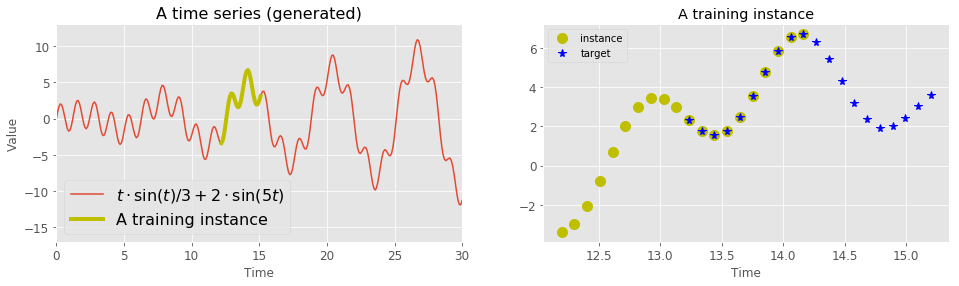

In [120]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

predoff=offset
n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + predoff), n_steps + predoff)

plt.style.use('ggplot')
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=16)
plt.plot(t, time_series(t), label=r"$t \cdot \sin(t) / 3 + 2 \cdot \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "y-", linewidth=4, label="A training instance")
plt.legend(loc="lower left", fontsize=16)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance")
plt.plot(t_instance[:-predoff], time_series(t_instance[:-predoff]), "yo", markersize=10, label="instance")
plt.plot(t_instance[predoff:], time_series(t_instance[predoff:]), "b*", markersize=8, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

In [121]:
X_batch, y_batch = next_batch(1, n_steps)

Ts
[[26.62000058 26.72000058 26.82000058 26.92000058 27.02000058 27.12000058
  27.22000058 27.32000058 27.42000058 27.52000058 27.62000058 27.72000058
  27.82000058 27.92000058 28.02000058 28.12000058 28.22000058 28.32000058
  28.42000058 28.52000058 28.62000058 28.72000058 28.82000058 28.92000058
  29.02000058 29.12000058 29.22000058 29.32000058 29.42000058 29.52000058]]


In [122]:
next_batch(1, 20)

Ts
[[20.49583037 20.59583037 20.69583037 20.79583037 20.89583037 20.99583037
  21.09583037 21.19583037 21.29583037 21.39583037 21.49583037 21.59583037
  21.69583037 21.79583037 21.89583037 21.99583037 22.09583037 22.19583037
  22.29583037 22.39583037 22.49583037 22.59583037 22.69583037 22.79583037
  22.89583037 22.99583037 23.09583037 23.19583037 23.29583037 23.39583037]]


(array([[[ 8.67175078],
         [ 8.03816824],
         [ 7.02290423],
         [ 5.84538455],
         [ 4.74877671],
         [ 3.94075692],
         [ 3.54312906],
         [ 3.56262725],
         [ 3.89004596],
         [ 4.32790384],
         [ 4.63986027],
         [ 4.60977619],
         [ 4.0959478 ],
         [ 3.06722281],
         [ 1.61214294],
         [-0.08114022],
         [-1.76927426],
         [-3.21158342],
         [-4.22726091],
         [-4.73789088]]]), array([[[ 4.63986027],
         [ 4.60977619],
         [ 4.0959478 ],
         [ 3.06722281],
         [ 1.61214294],
         [-0.08114022],
         [-1.76927426],
         [-3.21158342],
         [-4.22726091],
         [-4.73789088],
         [-4.78490681],
         [-4.51772979],
         [-4.15550839],
         [-3.9318451 ],
         [-4.03605923],
         [-4.56538339],
         [-5.49981325],
         [-6.70578283],
         [-7.96777877],
         [-9.04016588]]]))

## Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [123]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps+predoff, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [124]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [125]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [126]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [127]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [128]:
saver = tf.train.Saver()

In [129]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

Ts
[[10.48712333 10.58712333 10.68712333 ... 13.18712333 13.28712333
  13.38712333]
 [26.62000058 26.72000058 26.82000058 ... 29.32000058 29.42000058
  29.52000058]
 [20.49583037 20.59583037 20.69583037 ... 23.19583037 23.29583037
  23.39583037]
 ...
 [14.56190459 14.66190459 14.76190459 ... 17.26190459 17.36190459
  17.46190459]
 [15.30788782 15.40788782 15.50788782 ... 18.00788782 18.10788782
  18.20788782]
 [ 5.17592475  5.27592475  5.37592475 ...  7.87592475  7.97592475
   8.07592475]]
0 	MSE: 15.434632
Ts
[[27.14836958 27.24836958 27.34836958 ... 29.84836958 29.94836958
  30.04836958]
 [21.70371905 21.80371905 21.90371905 ... 24.40371905 24.50371905
  24.60371905]
 [26.30597036 26.40597036 26.50597036 ... 29.00597036 29.10597036
  29.20597036]
 ...
 [11.97114851 12.07114851 12.17114851 ... 14.67114851 14.77114851
  14.87114851]
 [ 0.71173555  0.81173555  0.91173555 ...  3.41173555  3.51173555
   3.61173555]
 [ 3.02095996  3.12095996  3.22095996 ...  5.72095996  5.82095996
   5.920

Ts
[[19.83416335 19.93416335 20.03416335 ... 22.53416335 22.63416335
  22.73416335]
 [23.43637319 23.53637319 23.63637319 ... 26.13637319 26.23637319
  26.33637319]
 [19.52920093 19.62920093 19.72920093 ... 22.22920093 22.32920093
  22.42920093]
 ...
 [27.12857995 27.22857995 27.32857995 ... 29.82857995 29.92857995
  30.02857995]
 [20.99025129 21.09025129 21.19025129 ... 23.69025129 23.79025129
  23.89025129]
 [ 3.64241472  3.74241472  3.84241472 ...  6.34241472  6.44241472
   6.54241472]]
Ts
[[21.23136949 21.33136949 21.43136949 ... 23.93136949 24.03136949
  24.13136949]
 [ 0.68843366  0.78843366  0.88843366 ...  3.38843366  3.48843366
   3.58843366]
 [ 0.61945944  0.71945944  0.81945944 ...  3.31945944  3.41945944
   3.51945944]
 ...
 [ 0.91073303  1.01073303  1.11073303 ...  3.61073303  3.71073303
   3.81073303]
 [25.78373974 25.88373974 25.98373974 ... 28.48373974 28.58373974
  28.68373974]
 [17.26620881 17.36620881 17.46620881 ... 19.96620881 20.06620881
  20.16620881]]
Ts
[[22.30

Ts
[[ 9.76697495  9.86697495  9.96697495 ... 12.46697495 12.56697495
  12.66697495]
 [ 3.10794677  3.20794677  3.30794677 ...  5.80794677  5.90794677
   6.00794677]
 [22.63058588 22.73058588 22.83058588 ... 25.33058588 25.43058588
  25.53058588]
 ...
 [13.90747184 14.00747184 14.10747184 ... 16.60747184 16.70747184
  16.80747184]
 [ 7.9596746   8.0596746   8.1596746  ... 10.6596746  10.7596746
  10.8596746 ]
 [ 3.74719416  3.84719416  3.94719416 ...  6.44719416  6.54719416
   6.64719416]]
Ts
[[17.62761551 17.72761551 17.82761551 ... 20.32761551 20.42761551
  20.52761551]
 [ 1.52129698  1.62129698  1.72129698 ...  4.22129698  4.32129698
   4.42129698]
 [20.96206656 21.06206656 21.16206656 ... 23.66206656 23.76206656
  23.86206656]
 ...
 [14.01123208 14.11123208 14.21123208 ... 16.71123208 16.81123208
  16.91123208]
 [12.11641581 12.21641581 12.31641581 ... 14.81641581 14.91641581
  15.01641581]
 [12.81558894 12.91558894 13.01558894 ... 15.51558894 15.61558894
  15.71558894]]
Ts
[[ 5.848

Ts
[[12.07644778 12.17644778 12.27644778 ... 14.77644778 14.87644778
  14.97644778]
 [10.61313359 10.71313359 10.81313359 ... 13.31313359 13.41313359
  13.51313359]
 [25.62170051 25.72170051 25.82170051 ... 28.32170051 28.42170051
  28.52170051]
 ...
 [16.86858438 16.96858438 17.06858438 ... 19.56858438 19.66858438
  19.76858438]
 [ 4.56453519  4.66453519  4.76453519 ...  7.26453519  7.36453519
   7.46453519]
 [ 6.54675933  6.64675933  6.74675933 ...  9.24675933  9.34675933
   9.44675933]]
Ts
[[ 0.6638171   0.7638171   0.8638171  ...  3.3638171   3.4638171
   3.5638171 ]
 [23.37852176 23.47852176 23.57852176 ... 26.07852176 26.17852176
  26.27852176]
 [27.29133669 27.39133669 27.49133669 ... 29.99133669 30.09133669
  30.19133669]
 ...
 [11.04802483 11.14802483 11.24802483 ... 13.74802483 13.84802483
  13.94802483]
 [14.83833643 14.93833643 15.03833643 ... 17.53833643 17.63833643
  17.73833643]
 [ 4.51828603  4.61828603  4.71828603 ...  7.21828603  7.31828603
   7.41828603]]
Ts
[[16.015

Ts
[[10.8094262  10.9094262  11.0094262  ... 13.5094262  13.6094262
  13.7094262 ]
 [27.06777192 27.16777192 27.26777192 ... 29.76777192 29.86777192
  29.96777192]
 [19.52065512 19.62065512 19.72065512 ... 22.22065512 22.32065512
  22.42065512]
 ...
 [16.96511083 17.06511083 17.16511083 ... 19.66511083 19.76511083
  19.86511083]
 [11.99385042 12.09385042 12.19385042 ... 14.69385042 14.79385042
  14.89385042]
 [ 0.75898627  0.85898627  0.95898627 ...  3.45898627  3.55898627
   3.65898627]]
Ts
[[21.93804207 22.03804207 22.13804207 ... 24.63804207 24.73804207
  24.83804207]
 [ 0.29437029  0.39437029  0.49437029 ...  2.99437029  3.09437029
   3.19437029]
 [21.33291704 21.43291704 21.53291704 ... 24.03291704 24.13291704
  24.23291704]
 ...
 [ 7.21369597  7.31369597  7.41369597 ...  9.91369597 10.01369597
  10.11369597]
 [12.59842288 12.69842288 12.79842288 ... 15.29842288 15.39842288
  15.49842288]
 [19.40144951 19.50144951 19.60144951 ... 22.10144951 22.20144951
  22.30144951]]
Ts
[[20.528

Ts
[[ 2.48565147  2.58565147  2.68565147 ...  5.18565147  5.28565147
   5.38565147]
 [24.21985933 24.31985933 24.41985933 ... 26.91985933 27.01985933
  27.11985933]
 [ 8.97735738  9.07735738  9.17735738 ... 11.67735738 11.77735738
  11.87735738]
 ...
 [ 9.95483432 10.05483432 10.15483432 ... 12.65483432 12.75483432
  12.85483432]
 [22.64803909 22.74803909 22.84803909 ... 25.34803909 25.44803909
  25.54803909]
 [ 8.25163836  8.35163836  8.45163836 ... 10.95163836 11.05163836
  11.15163836]]
Ts
[[15.9939617  16.0939617  16.1939617  ... 18.6939617  18.7939617
  18.8939617 ]
 [20.8711367  20.9711367  21.0711367  ... 23.5711367  23.6711367
  23.7711367 ]
 [10.61076547 10.71076547 10.81076547 ... 13.31076547 13.41076547
  13.51076547]
 ...
 [ 2.0740974   2.1740974   2.2740974  ...  4.7740974   4.8740974
   4.9740974 ]
 [27.79929969 27.89929969 27.99929969 ... 30.49929969 30.59929969
  30.69929969]
 [11.42103863 11.52103863 11.62103863 ... 14.12103863 14.22103863
  14.32103863]]
Ts
[[ 8.04727

Ts
[[ 3.5647326   3.6647326   3.7647326  ...  6.2647326   6.3647326
   6.4647326 ]
 [ 4.91882434  5.01882434  5.11882434 ...  7.61882434  7.71882434
   7.81882434]
 [26.88745804 26.98745804 27.08745804 ... 29.58745804 29.68745804
  29.78745804]
 ...
 [ 5.34945232  5.44945232  5.54945232 ...  8.04945232  8.14945232
   8.24945232]
 [12.34113842 12.44113842 12.54113842 ... 15.04113842 15.14113842
  15.24113842]
 [16.37319063 16.47319063 16.57319063 ... 19.07319063 19.17319063
  19.27319063]]
Ts
[[22.85437985 22.95437985 23.05437985 ... 25.55437985 25.65437985
  25.75437985]
 [27.67133922 27.77133922 27.87133922 ... 30.37133922 30.47133922
  30.57133922]
 [10.8878419  10.9878419  11.0878419  ... 13.5878419  13.6878419
  13.7878419 ]
 ...
 [25.78994562 25.88994562 25.98994562 ... 28.48994562 28.58994562
  28.68994562]
 [ 8.98619227  9.08619227  9.18619227 ... 11.68619227 11.78619227
  11.88619227]
 [ 7.06307935  7.16307935  7.26307935 ...  9.76307935  9.86307935
   9.96307935]]
Ts
[[14.9581

Ts
[[12.55919138 12.65919138 12.75919138 ... 15.25919138 15.35919138
  15.45919138]
 [17.53485504 17.63485504 17.73485504 ... 20.23485504 20.33485504
  20.43485504]
 [ 4.09844586  4.19844586  4.29844586 ...  6.79844586  6.89844586
   6.99844586]
 ...
 [11.97537006 12.07537006 12.17537006 ... 14.67537006 14.77537006
  14.87537006]
 [26.76855189 26.86855189 26.96855189 ... 29.46855189 29.56855189
  29.66855189]
 [ 6.0125835   6.1125835   6.2125835  ...  8.7125835   8.8125835
   8.9125835 ]]
Ts
[[14.46659928 14.56659928 14.66659928 ... 17.16659928 17.26659928
  17.36659928]
 [20.60848631 20.70848631 20.80848631 ... 23.30848631 23.40848631
  23.50848631]
 [15.59164357 15.69164357 15.79164357 ... 18.29164357 18.39164357
  18.49164357]
 ...
 [ 0.9362636   1.0362636   1.1362636  ...  3.6362636   3.7362636
   3.8362636 ]
 [13.16697439 13.26697439 13.36697439 ... 15.86697439 15.96697439
  16.06697439]
 [26.72453546 26.82453546 26.92453546 ... 29.42453546 29.52453546
  29.62453546]]
Ts
[[ 3.2389

Ts
[[ 9.83407655  9.93407655 10.03407655 ... 12.53407655 12.63407655
  12.73407655]
 [23.44271999 23.54271999 23.64271999 ... 26.14271999 26.24271999
  26.34271999]
 [ 1.87031816  1.97031816  2.07031816 ...  4.57031816  4.67031816
   4.77031816]
 ...
 [24.89458715 24.99458715 25.09458715 ... 27.59458715 27.69458715
  27.79458715]
 [26.2591618  26.3591618  26.4591618  ... 28.9591618  29.0591618
  29.1591618 ]
 [ 1.50159493  1.60159493  1.70159493 ...  4.20159493  4.30159493
   4.40159493]]
Ts
[[14.02714045 14.12714045 14.22714045 ... 16.72714045 16.82714045
  16.92714045]
 [10.49900737 10.59900737 10.69900737 ... 13.19900737 13.29900737
  13.39900737]
 [17.52403512 17.62403512 17.72403512 ... 20.22403512 20.32403512
  20.42403512]
 ...
 [ 6.04626971  6.14626971  6.24626971 ...  8.74626971  8.84626971
   8.94626971]
 [ 3.5799069   3.6799069   3.7799069  ...  6.2799069   6.3799069
   6.4799069 ]
 [ 8.74736514  8.84736514  8.94736514 ... 11.44736514 11.54736514
  11.64736514]]
Ts
[[14.4027

Ts
[[ 8.83369778  8.93369778  9.03369778 ... 11.53369778 11.63369778
  11.73369778]
 [22.19004709 22.29004709 22.39004709 ... 24.89004709 24.99004709
  25.09004709]
 [ 3.65269764  3.75269764  3.85269764 ...  6.35269764  6.45269764
   6.55269764]
 ...
 [ 2.92621175  3.02621175  3.12621175 ...  5.62621175  5.72621175
   5.82621175]
 [ 5.86375487  5.96375487  6.06375487 ...  8.56375487  8.66375487
   8.76375487]
 [27.16214533 27.26214533 27.36214533 ... 29.86214533 29.96214533
  30.06214533]]
Ts
[[18.70008622 18.80008622 18.90008622 ... 21.40008622 21.50008622
  21.60008622]
 [21.79948471 21.89948471 21.99948471 ... 24.49948471 24.59948471
  24.69948471]
 [21.7319033  21.8319033  21.9319033  ... 24.4319033  24.5319033
  24.6319033 ]
 ...
 [16.77691779 16.87691779 16.97691779 ... 19.47691779 19.57691779
  19.67691779]
 [ 2.67872389  2.77872389  2.87872389 ...  5.37872389  5.47872389
   5.57872389]
 [10.72165941 10.82165941 10.92165941 ... 13.42165941 13.52165941
  13.62165941]]
Ts
[[26.438

Ts
[[ 5.22757158  5.32757158  5.42757158 ...  7.92757158  8.02757158
   8.12757158]
 [ 5.55522042  5.65522042  5.75522042 ...  8.25522042  8.35522042
   8.45522042]
 [13.22888921 13.32888921 13.42888921 ... 15.92888921 16.02888921
  16.12888921]
 ...
 [17.99849825 18.09849825 18.19849825 ... 20.69849825 20.79849825
  20.89849825]
 [14.55278962 14.65278962 14.75278962 ... 17.25278962 17.35278962
  17.45278962]
 [19.09031072 19.19031072 19.29031072 ... 21.79031072 21.89031072
  21.99031072]]
Ts
[[12.58549503 12.68549503 12.78549503 ... 15.28549503 15.38549503
  15.48549503]
 [ 6.76679433  6.86679433  6.96679433 ...  9.46679433  9.56679433
   9.66679433]
 [ 0.03971016  0.13971016  0.23971016 ...  2.73971016  2.83971016
   2.93971016]
 ...
 [ 8.16826884  8.26826884  8.36826884 ... 10.86826884 10.96826884
  11.06826884]
 [ 6.34101137  6.44101137  6.54101137 ...  9.04101137  9.14101137
   9.24101137]
 [ 3.61581931  3.71581931  3.81581931 ...  6.31581931  6.41581931
   6.51581931]]
Ts
[[26.48

Ts
[[13.99076682 14.09076682 14.19076682 ... 16.69076682 16.79076682
  16.89076682]
 [20.90890963 21.00890963 21.10890963 ... 23.60890963 23.70890963
  23.80890963]
 [15.75466986 15.85466986 15.95466986 ... 18.45466986 18.55466986
  18.65466986]
 ...
 [12.471352   12.571352   12.671352   ... 15.171352   15.271352
  15.371352  ]
 [ 9.94265346 10.04265346 10.14265346 ... 12.64265346 12.74265346
  12.84265346]
 [13.87851763 13.97851763 14.07851763 ... 16.57851763 16.67851763
  16.77851763]]
300 	MSE: 5.1402264
Ts
[[24.36921297 24.46921297 24.56921297 ... 27.06921297 27.16921297
  27.26921297]
 [21.72412028 21.82412028 21.92412028 ... 24.42412028 24.52412028
  24.62412028]
 [ 2.35170604  2.45170604  2.55170604 ...  5.05170604  5.15170604
   5.25170604]
 ...
 [15.65371606 15.75371606 15.85371606 ... 18.35371606 18.45371606
  18.55371606]
 [18.74596014 18.84596014 18.94596014 ... 21.44596014 21.54596014
  21.64596014]
 [ 0.74740844  0.84740844  0.94740844 ...  3.44740844  3.54740844
   3.647

Ts
[[ 2.24115707  2.34115707  2.44115707 ...  4.94115707  5.04115707
   5.14115707]
 [21.15397392 21.25397392 21.35397392 ... 23.85397392 23.95397392
  24.05397392]
 [ 0.26617367  0.36617367  0.46617367 ...  2.96617367  3.06617367
   3.16617367]
 ...
 [27.27034147 27.37034147 27.47034147 ... 29.97034147 30.07034147
  30.17034147]
 [ 1.27411866  1.37411866  1.47411866 ...  3.97411866  4.07411866
   4.17411866]
 [26.62710922 26.72710922 26.82710922 ... 29.32710922 29.42710922
  29.52710922]]
Ts
[[16.29424199 16.39424199 16.49424199 ... 18.99424199 19.09424199
  19.19424199]
 [22.28037602 22.38037602 22.48037602 ... 24.98037602 25.08037602
  25.18037602]
 [12.0509933  12.1509933  12.2509933  ... 14.7509933  14.8509933
  14.9509933 ]
 ...
 [24.01016072 24.11016072 24.21016072 ... 26.71016072 26.81016072
  26.91016072]
 [25.38672681 25.48672681 25.58672681 ... 28.08672681 28.18672681
  28.28672681]
 [11.44093918 11.54093918 11.64093918 ... 14.14093918 14.24093918
  14.34093918]]
Ts
[[23.707

Ts
[[21.97544299 22.07544299 22.17544299 ... 24.67544299 24.77544299
  24.87544299]
 [ 3.13918215  3.23918215  3.33918215 ...  5.83918215  5.93918215
   6.03918215]
 [10.66997894 10.76997894 10.86997894 ... 13.36997894 13.46997894
  13.56997894]
 ...
 [ 7.38355115  7.48355115  7.58355115 ... 10.08355115 10.18355115
  10.28355115]
 [ 3.54539141  3.64539141  3.74539141 ...  6.24539141  6.34539141
   6.44539141]
 [10.35307022 10.45307022 10.55307022 ... 13.05307022 13.15307022
  13.25307022]]
Ts
[[20.67959714 20.77959714 20.87959714 ... 23.37959714 23.47959714
  23.57959714]
 [ 8.22966471  8.32966471  8.42966471 ... 10.92966471 11.02966471
  11.12966471]
 [16.09168971 16.19168971 16.29168971 ... 18.79168971 18.89168971
  18.99168971]
 ...
 [17.10187797 17.20187797 17.30187797 ... 19.80187797 19.90187797
  20.00187797]
 [ 8.91976675  9.01976675  9.11976675 ... 11.61976675 11.71976675
  11.81976675]
 [21.62741622 21.72741622 21.82741622 ... 24.32741622 24.42741622
  24.52741622]]
Ts
[[27.20

Ts
[[25.87073748 25.97073748 26.07073748 ... 28.57073748 28.67073748
  28.77073748]
 [ 4.51107735  4.61107735  4.71107735 ...  7.21107735  7.31107735
   7.41107735]
 [16.71773659 16.81773659 16.91773659 ... 19.41773659 19.51773659
  19.61773659]
 ...
 [24.92437815 25.02437815 25.12437815 ... 27.62437815 27.72437815
  27.82437815]
 [ 4.84314669  4.94314669  5.04314669 ...  7.54314669  7.64314669
   7.74314669]
 [25.84044889 25.94044889 26.04044889 ... 28.54044889 28.64044889
  28.74044889]]
Ts
[[14.63800053 14.73800053 14.83800053 ... 17.33800053 17.43800053
  17.53800053]
 [20.03594979 20.13594979 20.23594979 ... 22.73594979 22.83594979
  22.93594979]
 [ 3.08684563  3.18684563  3.28684563 ...  5.78684563  5.88684563
   5.98684563]
 ...
 [ 9.12794172  9.22794172  9.32794172 ... 11.82794172 11.92794172
  12.02794172]
 [15.17266671 15.27266671 15.37266671 ... 17.87266671 17.97266671
  18.07266671]
 [ 4.76600978  4.86600978  4.96600978 ...  7.46600978  7.56600978
   7.66600978]]
Ts
[[ 0.62

Ts
[[24.06789249 24.16789249 24.26789249 ... 26.76789249 26.86789249
  26.96789249]
 [27.12509639 27.22509639 27.32509639 ... 29.82509639 29.92509639
  30.02509639]
 [18.21341383 18.31341383 18.41341383 ... 20.91341383 21.01341383
  21.11341383]
 ...
 [ 0.70815945  0.80815945  0.90815945 ...  3.40815945  3.50815945
   3.60815945]
 [16.8810975  16.9810975  17.0810975  ... 19.5810975  19.6810975
  19.7810975 ]
 [ 8.11148858  8.21148858  8.31148858 ... 10.81148858 10.91148858
  11.01148858]]
Ts
[[12.12251939 12.22251939 12.32251939 ... 14.82251939 14.92251939
  15.02251939]
 [13.6771455  13.7771455  13.8771455  ... 16.3771455  16.4771455
  16.5771455 ]
 [ 1.8063531   1.9063531   2.0063531  ...  4.5063531   4.6063531
   4.7063531 ]
 ...
 [ 0.9599838   1.0599838   1.1599838  ...  3.6599838   3.7599838
   3.8599838 ]
 [25.37962371 25.47962371 25.57962371 ... 28.07962371 28.17962371
  28.27962371]
 [25.71664681 25.81664681 25.91664681 ... 28.41664681 28.51664681
  28.61664681]]
Ts
[[15.718930

Ts
[[ 1.25947186  1.35947186  1.45947186 ...  3.95947186  4.05947186
   4.15947186]
 [ 0.81734353  0.91734353  1.01734353 ...  3.51734353  3.61734353
   3.71734353]
 [17.16189581 17.26189581 17.36189581 ... 19.86189581 19.96189581
  20.06189581]
 ...
 [ 1.16143616  1.26143616  1.36143616 ...  3.86143616  3.96143616
   4.06143616]
 [ 2.8494423   2.9494423   3.0494423  ...  5.5494423   5.6494423
   5.7494423 ]
 [ 2.44607481  2.54607481  2.64607481 ...  5.14607481  5.24607481
   5.34607481]]
Ts
[[15.32667454 15.42667454 15.52667454 ... 18.02667454 18.12667454
  18.22667454]
 [ 6.03243164  6.13243164  6.23243164 ...  8.73243164  8.83243164
   8.93243164]
 [24.08575784 24.18575784 24.28575784 ... 26.78575784 26.88575784
  26.98575784]
 ...
 [15.41073059 15.51073059 15.61073059 ... 18.11073059 18.21073059
  18.31073059]
 [17.36948819 17.46948819 17.56948819 ... 20.06948819 20.16948819
  20.26948819]
 [18.61046358 18.71046358 18.81046358 ... 21.31046358 21.41046358
  21.51046358]]
Ts
[[15.718

Ts
[[27.09459755 27.19459755 27.29459755 ... 29.79459755 29.89459755
  29.99459755]
 [ 2.71816973  2.81816973  2.91816973 ...  5.41816973  5.51816973
   5.61816973]
 [25.27479277 25.37479277 25.47479277 ... 27.97479277 28.07479277
  28.17479277]
 ...
 [ 0.08344366  0.18344366  0.28344366 ...  2.78344366  2.88344366
   2.98344366]
 [ 7.09025261  7.19025261  7.29025261 ...  9.79025261  9.89025261
   9.99025261]
 [ 7.8039389   7.9039389   8.0039389  ... 10.5039389  10.6039389
  10.7039389 ]]
Ts
[[ 2.61780433  2.71780433  2.81780433 ...  5.31780433  5.41780433
   5.51780433]
 [ 7.83146037  7.93146037  8.03146037 ... 10.53146037 10.63146037
  10.73146037]
 [ 8.99141693  9.09141693  9.19141693 ... 11.69141693 11.79141693
  11.89141693]
 ...
 [ 6.52973767  6.62973767  6.72973767 ...  9.22973767  9.32973767
   9.42973767]
 [ 8.84562791  8.94562791  9.04562791 ... 11.54562791 11.64562791
  11.74562791]
 [16.22710162 16.32710162 16.42710162 ... 18.92710162 19.02710162
  19.12710162]]
Ts
[[10.213

Ts
[[ 7.14099875  7.24099875  7.34099875 ...  9.84099875  9.94099875
  10.04099875]
 [ 4.98037774  5.08037774  5.18037774 ...  7.68037774  7.78037774
   7.88037774]
 [ 4.84573458  4.94573458  5.04573458 ...  7.54573458  7.64573458
   7.74573458]
 ...
 [18.14300054 18.24300054 18.34300054 ... 20.84300054 20.94300054
  21.04300054]
 [22.68695644 22.78695644 22.88695644 ... 25.38695644 25.48695644
  25.58695644]
 [ 3.90752893  4.00752893  4.10752893 ...  6.60752893  6.70752893
   6.80752893]]
Ts
[[21.93744416 22.03744416 22.13744416 ... 24.63744416 24.73744416
  24.83744416]
 [27.97974273 28.07974273 28.17974273 ... 30.67974273 30.77974273
  30.87974273]
 [23.82918856 23.92918856 24.02918856 ... 26.52918856 26.62918856
  26.72918856]
 ...
 [21.35920826 21.45920826 21.55920826 ... 24.05920826 24.15920826
  24.25920826]
 [17.97285216 18.07285216 18.17285216 ... 20.67285216 20.77285216
  20.87285216]
 [26.98888831 27.08888831 27.18888831 ... 29.68888831 29.78888831
  29.88888831]]
Ts
[[16.44

Ts
[[ 1.69596233  1.79596233  1.89596233 ...  4.39596233  4.49596233
   4.59596233]
 [ 5.68981261  5.78981261  5.88981261 ...  8.38981261  8.48981261
   8.58981261]
 [13.75537117 13.85537117 13.95537117 ... 16.45537117 16.55537117
  16.65537117]
 ...
 [15.37348232 15.47348232 15.57348232 ... 18.07348232 18.17348232
  18.27348232]
 [ 6.95938762  7.05938762  7.15938762 ...  9.65938762  9.75938762
   9.85938762]
 [14.60320492 14.70320492 14.80320492 ... 17.30320492 17.40320492
  17.50320492]]
Ts
[[ 0.66065199  0.76065199  0.86065199 ...  3.36065199  3.46065199
   3.56065199]
 [12.08882479 12.18882479 12.28882479 ... 14.78882479 14.88882479
  14.98882479]
 [16.03343905 16.13343905 16.23343905 ... 18.73343905 18.83343905
  18.93343905]
 ...
 [26.40303388 26.50303388 26.60303388 ... 29.10303388 29.20303388
  29.30303388]
 [11.16245458 11.26245458 11.36245458 ... 13.86245458 13.96245458
  14.06245458]
 [ 6.43430075  6.53430075  6.63430075 ...  9.13430075  9.23430075
   9.33430075]]
Ts
[[ 9.14

Ts
[[25.41852912 25.51852912 25.61852912 ... 28.11852912 28.21852912
  28.31852912]
 [14.74475604 14.84475604 14.94475604 ... 17.44475604 17.54475604
  17.64475604]
 [15.85288717 15.95288717 16.05288717 ... 18.55288717 18.65288717
  18.75288717]
 ...
 [ 8.27985468  8.37985468  8.47985468 ... 10.97985468 11.07985468
  11.17985468]
 [ 0.25814864  0.35814864  0.45814864 ...  2.95814864  3.05814864
   3.15814864]
 [ 5.50873463  5.60873463  5.70873463 ...  8.20873463  8.30873463
   8.40873463]]
Ts
[[ 3.06648977  3.16648977  3.26648977 ...  5.76648977  5.86648977
   5.96648977]
 [ 8.93182568  9.03182568  9.13182568 ... 11.63182568 11.73182568
  11.83182568]
 [23.12460297 23.22460297 23.32460297 ... 25.82460297 25.92460297
  26.02460297]
 ...
 [ 9.74103034  9.84103034  9.94103034 ... 12.44103034 12.54103034
  12.64103034]
 [27.47776408 27.57776408 27.67776408 ... 30.17776408 30.27776408
  30.37776408]
 [25.95049426 26.05049426 26.15049426 ... 28.65049426 28.75049426
  28.85049426]]
Ts
[[27.21

Ts
[[11.90224888 12.00224888 12.10224888 ... 14.60224888 14.70224888
  14.80224888]
 [10.08053083 10.18053083 10.28053083 ... 12.78053083 12.88053083
  12.98053083]
 [21.8955479  21.9955479  22.0955479  ... 24.5955479  24.6955479
  24.7955479 ]
 ...
 [10.97042159 11.07042159 11.17042159 ... 13.67042159 13.77042159
  13.87042159]
 [ 6.5820555   6.6820555   6.7820555  ...  9.2820555   9.3820555
   9.4820555 ]
 [18.51928379 18.61928379 18.71928379 ... 21.21928379 21.31928379
  21.41928379]]
Ts
[[16.05226525 16.15226525 16.25226525 ... 18.75226525 18.85226525
  18.95226525]
 [ 9.38694123  9.48694123  9.58694123 ... 12.08694123 12.18694123
  12.28694123]
 [ 9.62260772  9.72260772  9.82260772 ... 12.32260772 12.42260772
  12.52260772]
 ...
 [18.09722447 18.19722447 18.29722447 ... 20.79722447 20.89722447
  20.99722447]
 [ 5.71891842  5.81891842  5.91891842 ...  8.41891842  8.51891842
   8.61891842]
 [19.43167196 19.53167196 19.63167196 ... 22.13167196 22.23167196
  22.33167196]]
Ts
[[ 0.0871

Ts
[[ 8.21305734  8.31305734  8.41305734 ... 10.91305734 11.01305734
  11.11305734]
 [ 7.24151099  7.34151099  7.44151099 ...  9.94151099 10.04151099
  10.14151099]
 [23.49009806 23.59009806 23.69009806 ... 26.19009806 26.29009806
  26.39009806]
 ...
 [20.10319099 20.20319099 20.30319099 ... 22.80319099 22.90319099
  23.00319099]
 [25.09434967 25.19434967 25.29434967 ... 27.79434967 27.89434967
  27.99434967]
 [21.64901139 21.74901139 21.84901139 ... 24.34901139 24.44901139
  24.54901139]]
Ts
[[25.4759107  25.5759107  25.6759107  ... 28.1759107  28.2759107
  28.3759107 ]
 [12.07190886 12.17190886 12.27190886 ... 14.77190886 14.87190886
  14.97190886]
 [25.31816714 25.41816714 25.51816714 ... 28.01816714 28.11816714
  28.21816714]
 ...
 [ 8.09222524  8.19222524  8.29222524 ... 10.79222524 10.89222524
  10.99222524]
 [ 4.24115693  4.34115693  4.44115693 ...  6.94115693  7.04115693
   7.14115693]
 [17.89935174 17.99935174 18.09935174 ... 20.59935174 20.69935174
  20.79935174]]
Ts
[[13.666

Ts
[[25.19856848 25.29856848 25.39856848 ... 27.89856848 27.99856848
  28.09856848]
 [ 4.24224391  4.34224391  4.44224391 ...  6.94224391  7.04224391
   7.14224391]
 [ 2.67231887  2.77231887  2.87231887 ...  5.37231887  5.47231887
   5.57231887]
 ...
 [ 6.69283673  6.79283673  6.89283673 ...  9.39283673  9.49283673
   9.59283673]
 [15.58916868 15.68916868 15.78916868 ... 18.28916868 18.38916868
  18.48916868]
 [19.86768294 19.96768294 20.06768294 ... 22.56768294 22.66768294
  22.76768294]]
Ts
[[ 8.49001701  8.59001701  8.69001701 ... 11.19001701 11.29001701
  11.39001701]
 [ 2.61318717  2.71318717  2.81318717 ...  5.31318717  5.41318717
   5.51318717]
 [ 8.71077723  8.81077723  8.91077723 ... 11.41077723 11.51077723
  11.61077723]
 ...
 [19.62020388 19.72020388 19.82020388 ... 22.32020388 22.42020388
  22.52020388]
 [18.13185265 18.23185265 18.33185265 ... 20.83185265 20.93185265
  21.03185265]
 [18.7435325  18.8435325  18.9435325  ... 21.4435325  21.5435325
  21.6435325 ]]
Ts
[[24.640

Ts
[[12.37708253 12.47708253 12.57708253 ... 15.07708253 15.17708253
  15.27708253]
 [22.90903019 23.00903019 23.10903019 ... 25.60903019 25.70903019
  25.80903019]
 [26.15219996 26.25219996 26.35219996 ... 28.85219996 28.95219996
  29.05219996]
 ...
 [ 3.51038499  3.61038499  3.71038499 ...  6.21038499  6.31038499
   6.41038499]
 [18.88507264 18.98507264 19.08507264 ... 21.58507264 21.68507264
  21.78507264]
 [ 5.81220446  5.91220446  6.01220446 ...  8.51220446  8.61220446
   8.71220446]]
Ts
[[14.25244935 14.35244935 14.45244935 ... 16.95244935 17.05244935
  17.15244935]
 [ 8.5732633   8.6732633   8.7732633  ... 11.2732633  11.3732633
  11.4732633 ]
 [26.0873218  26.1873218  26.2873218  ... 28.7873218  28.8873218
  28.9873218 ]
 ...
 [ 8.47624189  8.57624189  8.67624189 ... 11.17624189 11.27624189
  11.37624189]
 [20.87635231 20.97635231 21.07635231 ... 23.57635231 23.67635231
  23.77635231]
 [ 9.61564064  9.71564064  9.81564064 ... 12.31564064 12.41564064
  12.51564064]]
Ts
[[25.2794

Ts
[[13.55252177 13.65252177 13.75252177 ... 16.25252177 16.35252177
  16.45252177]
 [12.86763536 12.96763536 13.06763536 ... 15.56763536 15.66763536
  15.76763536]
 [19.36044397 19.46044397 19.56044397 ... 22.06044397 22.16044397
  22.26044397]
 ...
 [22.83006541 22.93006541 23.03006541 ... 25.53006541 25.63006541
  25.73006541]
 [ 0.98778867  1.08778867  1.18778867 ...  3.68778867  3.78778867
   3.88778867]
 [ 8.86647145  8.96647145  9.06647145 ... 11.56647145 11.66647145
  11.76647145]]
Ts
[[ 0.80023133  0.90023133  1.00023133 ...  3.50023133  3.60023133
   3.70023133]
 [ 1.12467507  1.22467507  1.32467507 ...  3.82467507  3.92467507
   4.02467507]
 [ 2.22642852  2.32642852  2.42642852 ...  4.92642852  5.02642852
   5.12642852]
 ...
 [11.42859203 11.52859203 11.62859203 ... 14.12859203 14.22859203
  14.32859203]
 [ 3.84815575  3.94815575  4.04815575 ...  6.54815575  6.64815575
   6.74815575]
 [17.64794236 17.74794236 17.84794236 ... 20.34794236 20.44794236
  20.54794236]]
Ts
[[24.46

Ts
[[19.22616775 19.32616775 19.42616775 ... 21.92616775 22.02616775
  22.12616775]
 [12.02805383 12.12805383 12.22805383 ... 14.72805383 14.82805383
  14.92805383]
 [17.55965766 17.65965766 17.75965766 ... 20.25965766 20.35965766
  20.45965766]
 ...
 [25.40460392 25.50460392 25.60460392 ... 28.10460392 28.20460392
  28.30460392]
 [20.88566465 20.98566465 21.08566465 ... 23.58566465 23.68566465
  23.78566465]
 [ 7.90875901  8.00875901  8.10875901 ... 10.60875901 10.70875901
  10.80875901]]
Ts
[[16.81420889 16.91420889 17.01420889 ... 19.51420889 19.61420889
  19.71420889]
 [ 3.95930111  4.05930111  4.15930111 ...  6.65930111  6.75930111
   6.85930111]
 [ 3.27769746  3.37769746  3.47769746 ...  5.97769746  6.07769746
   6.17769746]
 ...
 [27.75736976 27.85736976 27.95736976 ... 30.45736976 30.55736976
  30.65736976]
 [ 7.28262398  7.38262398  7.48262398 ...  9.98262398 10.08262398
  10.18262398]
 [ 9.026915    9.126915    9.226915   ... 11.726915   11.826915
  11.926915  ]]
Ts
[[ 9.5520

Ts
[[ 9.90387813 10.00387813 10.10387813 ... 12.60387813 12.70387813
  12.80387813]
 [10.52585401 10.62585401 10.72585401 ... 13.22585401 13.32585401
  13.42585401]
 [21.63705842 21.73705842 21.83705842 ... 24.33705842 24.43705842
  24.53705842]
 ...
 [22.34379762 22.44379762 22.54379762 ... 25.04379762 25.14379762
  25.24379762]
 [11.58763765 11.68763765 11.78763765 ... 14.28763765 14.38763765
  14.48763765]
 [16.41279317 16.51279317 16.61279317 ... 19.11279317 19.21279317
  19.31279317]]
Ts
[[ 4.58022346  4.68022346  4.78022346 ...  7.28022346  7.38022346
   7.48022346]
 [ 1.95191818  2.05191818  2.15191818 ...  4.65191818  4.75191818
   4.85191818]
 [24.63876917 24.73876917 24.83876917 ... 27.33876917 27.43876917
  27.53876917]
 ...
 [16.61819993 16.71819993 16.81819993 ... 19.31819993 19.41819993
  19.51819993]
 [25.73022764 25.83022764 25.93022764 ... 28.43022764 28.53022764
  28.63022764]
 [21.45480776 21.55480776 21.65480776 ... 24.15480776 24.25480776
  24.35480776]]
Ts
[[15.13

Ts
[[ 3.58558193  3.68558193  3.78558193 ...  6.28558193  6.38558193
   6.48558193]
 [ 1.71769948  1.81769948  1.91769948 ...  4.41769948  4.51769948
   4.61769948]
 [ 8.9163485   9.0163485   9.1163485  ... 11.6163485  11.7163485
  11.8163485 ]
 ...
 [11.51958647 11.61958647 11.71958647 ... 14.21958647 14.31958647
  14.41958647]
 [27.57064742 27.67064742 27.77064742 ... 30.27064742 30.37064742
  30.47064742]
 [19.01182961 19.11182961 19.21182961 ... 21.71182961 21.81182961
  21.91182961]]
Ts
[[20.82420894 20.92420894 21.02420894 ... 23.52420894 23.62420894
  23.72420894]
 [ 5.38441186  5.48441186  5.58441186 ...  8.08441186  8.18441186
   8.28441186]
 [23.44825344 23.54825344 23.64825344 ... 26.14825344 26.24825344
  26.34825344]
 ...
 [23.67154183 23.77154183 23.87154183 ... 26.37154183 26.47154183
  26.57154183]
 [ 6.241381    6.341381    6.441381   ...  8.941381    9.041381
   9.141381  ]
 [15.95346889 16.05346889 16.15346889 ... 18.65346889 18.75346889
  18.85346889]]
Ts
[[10.08267

Ts
[[18.3642036  18.4642036  18.5642036  ... 21.0642036  21.1642036
  21.2642036 ]
 [20.89059191 20.99059191 21.09059191 ... 23.59059191 23.69059191
  23.79059191]
 [ 6.27925487  6.37925487  6.47925487 ...  8.97925487  9.07925487
   9.17925487]
 ...
 [ 7.54794409  7.64794409  7.74794409 ... 10.24794409 10.34794409
  10.44794409]
 [12.16095362 12.26095362 12.36095362 ... 14.86095362 14.96095362
  15.06095362]
 [13.64786356 13.74786356 13.84786356 ... 16.34786356 16.44786356
  16.54786356]]
Ts
[[ 8.36953715  8.46953715  8.56953715 ... 11.06953715 11.16953715
  11.26953715]
 [ 2.6548977   2.7548977   2.8548977  ...  5.3548977   5.4548977
   5.5548977 ]
 [ 3.5380583   3.6380583   3.7380583  ...  6.2380583   6.3380583
   6.4380583 ]
 ...
 [17.88070717 17.98070717 18.08070717 ... 20.58070717 20.68070717
  20.78070717]
 [23.19626408 23.29626408 23.39626408 ... 25.89626408 25.99626408
  26.09626408]
 [ 8.40774902  8.50774902  8.60774902 ... 11.10774902 11.20774902
  11.30774902]]
800 	MSE: 3.4

Ts
[[16.27895078 16.37895078 16.47895078 ... 18.97895078 19.07895078
  19.17895078]
 [15.01883173 15.11883173 15.21883173 ... 17.71883173 17.81883173
  17.91883173]
 [26.39534314 26.49534314 26.59534314 ... 29.09534314 29.19534314
  29.29534314]
 ...
 [21.13837515 21.23837515 21.33837515 ... 23.83837515 23.93837515
  24.03837515]
 [23.37416306 23.47416306 23.57416306 ... 26.07416306 26.17416306
  26.27416306]
 [21.87874549 21.97874549 22.07874549 ... 24.57874549 24.67874549
  24.77874549]]
Ts
[[27.41613466 27.51613466 27.61613466 ... 30.11613466 30.21613466
  30.31613466]
 [21.21853795 21.31853795 21.41853795 ... 23.91853795 24.01853795
  24.11853795]
 [ 5.88639852  5.98639852  6.08639852 ...  8.58639852  8.68639852
   8.78639852]
 ...
 [ 6.77630768  6.87630768  6.97630768 ...  9.47630768  9.57630768
   9.67630768]
 [ 2.89912453  2.99912453  3.09912453 ...  5.59912453  5.69912453
   5.79912453]
 [ 4.91743746  5.01743746  5.11743746 ...  7.61743746  7.71743746
   7.81743746]]
Ts
[[23.93

Ts
[[13.99920161 14.09920161 14.19920161 ... 16.69920161 16.79920161
  16.89920161]
 [23.57551638 23.67551638 23.77551638 ... 26.27551638 26.37551638
  26.47551638]
 [ 1.65246604  1.75246604  1.85246604 ...  4.35246604  4.45246604
   4.55246604]
 ...
 [14.16549338 14.26549338 14.36549338 ... 16.86549338 16.96549338
  17.06549338]
 [15.04406921 15.14406921 15.24406921 ... 17.74406921 17.84406921
  17.94406921]
 [ 9.41234123  9.51234123  9.61234123 ... 12.11234123 12.21234123
  12.31234123]]
Ts
[[27.32362816 27.42362816 27.52362816 ... 30.02362816 30.12362816
  30.22362816]
 [15.59491389 15.69491389 15.79491389 ... 18.29491389 18.39491389
  18.49491389]
 [24.89229453 24.99229453 25.09229453 ... 27.59229453 27.69229453
  27.79229453]
 ...
 [21.60764496 21.70764496 21.80764496 ... 24.30764496 24.40764496
  24.50764496]
 [13.55727173 13.65727173 13.75727173 ... 16.25727173 16.35727173
  16.45727173]
 [14.16970376 14.26970376 14.36970376 ... 16.86970376 16.96970376
  17.06970376]]
Ts
[[ 7.20

Ts
[[22.15140957 22.25140957 22.35140957 ... 24.85140957 24.95140957
  25.05140957]
 [25.72410882 25.82410882 25.92410882 ... 28.42410882 28.52410882
  28.62410882]
 [26.62757496 26.72757496 26.82757496 ... 29.32757496 29.42757496
  29.52757496]
 ...
 [20.6538758  20.7538758  20.8538758  ... 23.3538758  23.4538758
  23.5538758 ]
 [24.76729603 24.86729603 24.96729603 ... 27.46729603 27.56729603
  27.66729603]
 [16.49909795 16.59909795 16.69909795 ... 19.19909795 19.29909795
  19.39909795]]
Ts
[[12.19280293 12.29280293 12.39280293 ... 14.89280293 14.99280293
  15.09280293]
 [ 7.57590199  7.67590199  7.77590199 ... 10.27590199 10.37590199
  10.47590199]
 [16.32704736 16.42704736 16.52704736 ... 19.02704736 19.12704736
  19.22704736]
 ...
 [14.63564772 14.73564772 14.83564772 ... 17.33564772 17.43564772
  17.53564772]
 [16.11266823 16.21266823 16.31266823 ... 18.81266823 18.91266823
  19.01266823]
 [10.71058352 10.81058352 10.91058352 ... 13.41058352 13.51058352
  13.61058352]]
Ts
[[ 9.009

Ts
[[ 0.52330995  0.62330995  0.72330995 ...  3.22330995  3.32330995
   3.42330995]
 [22.1755193  22.2755193  22.3755193  ... 24.8755193  24.9755193
  25.0755193 ]
 [ 4.69784929  4.79784929  4.89784929 ...  7.39784929  7.49784929
   7.59784929]
 ...
 [ 1.09472216  1.19472216  1.29472216 ...  3.79472216  3.89472216
   3.99472216]
 [16.10219925 16.20219925 16.30219925 ... 18.80219925 18.90219925
  19.00219925]
 [20.92172776 21.02172776 21.12172776 ... 23.62172776 23.72172776
  23.82172776]]
Ts
[[26.36768777 26.46768777 26.56768777 ... 29.06768777 29.16768777
  29.26768777]
 [15.97265172 16.07265172 16.17265172 ... 18.67265172 18.77265172
  18.87265172]
 [22.23761899 22.33761899 22.43761899 ... 24.93761899 25.03761899
  25.13761899]
 ...
 [26.88212229 26.98212229 27.08212229 ... 29.58212229 29.68212229
  29.78212229]
 [ 6.17326199  6.27326199  6.37326199 ...  8.87326199  8.97326199
   9.07326199]
 [ 9.26217515  9.36217515  9.46217515 ... 11.96217515 12.06217515
  12.16217515]]
Ts
[[ 2.762

Ts
[[21.55455848 21.65455848 21.75455848 ... 24.25455848 24.35455848
  24.45455848]
 [ 7.49856657  7.59856657  7.69856657 ... 10.19856657 10.29856657
  10.39856657]
 [16.68050335 16.78050335 16.88050335 ... 19.38050335 19.48050335
  19.58050335]
 ...
 [17.37485362 17.47485362 17.57485362 ... 20.07485362 20.17485362
  20.27485362]
 [23.98880628 24.08880628 24.18880628 ... 26.68880628 26.78880628
  26.88880628]
 [ 3.40400219  3.50400219  3.60400219 ...  6.10400219  6.20400219
   6.30400219]]
Ts
[[ 5.89459269  5.99459269  6.09459269 ...  8.59459269  8.69459269
   8.79459269]
 [27.1682002  27.2682002  27.3682002  ... 29.8682002  29.9682002
  30.0682002 ]
 [24.84721933 24.94721933 25.04721933 ... 27.54721933 27.64721933
  27.74721933]
 ...
 [ 8.33491413  8.43491413  8.53491413 ... 11.03491413 11.13491413
  11.23491413]
 [18.14628661 18.24628661 18.34628661 ... 20.84628661 20.94628661
  21.04628661]
 [ 5.57291433  5.67291433  5.77291433 ...  8.27291433  8.37291433
   8.47291433]]
Ts
[[ 3.799

Ts
[[18.71888845 18.81888845 18.91888845 ... 21.41888845 21.51888845
  21.61888845]
 [18.6896716  18.7896716  18.8896716  ... 21.3896716  21.4896716
  21.5896716 ]
 [ 1.5775782   1.6775782   1.7775782  ...  4.2775782   4.3775782
   4.4775782 ]
 ...
 [14.91082036 15.01082036 15.11082036 ... 17.61082036 17.71082036
  17.81082036]
 [ 8.97233745  9.07233745  9.17233745 ... 11.67233745 11.77233745
  11.87233745]
 [15.96898579 16.06898579 16.16898579 ... 18.66898579 18.76898579
  18.86898579]]
Ts
[[ 2.29091924  2.39091924  2.49091924 ...  4.99091924  5.09091924
   5.19091924]
 [10.53245077 10.63245077 10.73245077 ... 13.23245077 13.33245077
  13.43245077]
 [ 6.64996103  6.74996103  6.84996103 ...  9.34996103  9.44996103
   9.54996103]
 ...
 [ 8.96012655  9.06012655  9.16012655 ... 11.66012655 11.76012655
  11.86012655]
 [22.0815894  22.1815894  22.2815894  ... 24.7815894  24.8815894
  24.9815894 ]
 [10.01609845 10.11609845 10.21609845 ... 12.71609845 12.81609845
  12.91609845]]
Ts
[[1.129966

Ts
[[19.50974073 19.60974073 19.70974073 ... 22.20974073 22.30974073
  22.40974073]
 [ 6.44222326  6.54222326  6.64222326 ...  9.14222326  9.24222326
   9.34222326]
 [21.04336897 21.14336897 21.24336897 ... 23.74336897 23.84336897
  23.94336897]
 ...
 [16.04491281 16.14491281 16.24491281 ... 18.74491281 18.84491281
  18.94491281]
 [19.615383   19.715383   19.815383   ... 22.315383   22.415383
  22.515383  ]
 [ 6.45955272  6.55955272  6.65955272 ...  9.15955272  9.25955272
   9.35955272]]
Ts
[[19.27945455 19.37945455 19.47945455 ... 21.97945455 22.07945455
  22.17945455]
 [ 9.0004587   9.1004587   9.2004587  ... 11.7004587  11.8004587
  11.9004587 ]
 [ 6.22781972  6.32781972  6.42781972 ...  8.92781972  9.02781972
   9.12781972]
 ...
 [19.629539   19.729539   19.829539   ... 22.329539   22.429539
  22.529539  ]
 [ 3.34370698  3.44370698  3.54370698 ...  6.04370698  6.14370698
   6.24370698]
 [13.42864447 13.52864447 13.62864447 ... 16.12864447 16.22864447
  16.32864447]]
Ts
[[ 7.6921518

Ts
[[ 0.30942975  0.40942975  0.50942975 ...  3.00942975  3.10942975
   3.20942975]
 [17.09535399 17.19535399 17.29535399 ... 19.79535399 19.89535399
  19.99535399]
 [16.1698753  16.2698753  16.3698753  ... 18.8698753  18.9698753
  19.0698753 ]
 ...
 [15.42236996 15.52236996 15.62236996 ... 18.12236996 18.22236996
  18.32236996]
 [21.66824296 21.76824296 21.86824296 ... 24.36824296 24.46824296
  24.56824296]
 [19.67905245 19.77905245 19.87905245 ... 22.37905245 22.47905245
  22.57905245]]
Ts
[[ 9.75999095  9.85999095  9.95999095 ... 12.45999095 12.55999095
  12.65999095]
 [20.93914646 21.03914646 21.13914646 ... 23.63914646 23.73914646
  23.83914646]
 [25.9190682  26.0190682  26.1190682  ... 28.6190682  28.7190682
  28.8190682 ]
 ...
 [ 4.9789419   5.0789419   5.1789419  ...  7.6789419   7.7789419
   7.8789419 ]
 [14.10670869 14.20670869 14.30670869 ... 16.80670869 16.90670869
  17.00670869]
 [12.28823797 12.38823797 12.48823797 ... 14.98823797 15.08823797
  15.18823797]]
Ts
[[18.38517

Ts
[[26.5464415  26.6464415  26.7464415  ... 29.2464415  29.3464415
  29.4464415 ]
 [22.69049561 22.79049561 22.89049561 ... 25.39049561 25.49049561
  25.59049561]
 [18.4608246  18.5608246  18.6608246  ... 21.1608246  21.2608246
  21.3608246 ]
 ...
 [ 3.7920554   3.8920554   3.9920554  ...  6.4920554   6.5920554
   6.6920554 ]
 [24.68877274 24.78877274 24.88877274 ... 27.38877274 27.48877274
  27.58877274]
 [27.29095012 27.39095012 27.49095012 ... 29.99095012 30.09095012
  30.19095012]]
Ts
[[27.09427431 27.19427431 27.29427431 ... 29.79427431 29.89427431
  29.99427431]
 [ 4.13550378  4.23550378  4.33550378 ...  6.83550378  6.93550378
   7.03550378]
 [15.38901019 15.48901019 15.58901019 ... 18.08901019 18.18901019
  18.28901019]
 ...
 [ 2.73537923  2.83537923  2.93537923 ...  5.43537923  5.53537923
   5.63537923]
 [12.21061233 12.31061233 12.41061233 ... 14.91061233 15.01061233
  15.11061233]
 [18.22429617 18.32429617 18.42429617 ... 20.92429617 21.02429617
  21.12429617]]
Ts
[[17.51091

Ts
[[ 7.04081394  7.14081394  7.24081394 ...  9.74081394  9.84081394
   9.94081394]
 [ 2.98223136  3.08223136  3.18223136 ...  5.68223136  5.78223136
   5.88223136]
 [11.078683   11.178683   11.278683   ... 13.778683   13.878683
  13.978683  ]
 ...
 [ 4.74873014  4.84873014  4.94873014 ...  7.44873014  7.54873014
   7.64873014]
 [ 7.94885671  8.04885671  8.14885671 ... 10.64885671 10.74885671
  10.84885671]
 [ 8.20698704  8.30698704  8.40698704 ... 10.90698704 11.00698704
  11.10698704]]
Ts
[[ 9.14964467  9.24964467  9.34964467 ... 11.84964467 11.94964467
  12.04964467]
 [17.94987423 18.04987423 18.14987423 ... 20.64987423 20.74987423
  20.84987423]
 [20.79259681 20.89259681 20.99259681 ... 23.49259681 23.59259681
  23.69259681]
 ...
 [18.99769279 19.09769279 19.19769279 ... 21.69769279 21.79769279
  21.89769279]
 [ 7.32719341  7.42719341  7.52719341 ... 10.02719341 10.12719341
  10.22719341]
 [13.01603358 13.11603358 13.21603358 ... 15.71603358 15.81603358
  15.91603358]]
Ts
[[22.7395

Ts
[[ 1.39438441  1.49438441  1.59438441 ...  4.09438441  4.19438441
   4.29438441]
 [15.34577454 15.44577454 15.54577454 ... 18.04577454 18.14577454
  18.24577454]
 [10.0057759  10.1057759  10.2057759  ... 12.7057759  12.8057759
  12.9057759 ]
 ...
 [ 1.88109246  1.98109246  2.08109246 ...  4.58109246  4.68109246
   4.78109246]
 [ 5.48677465  5.58677465  5.68677465 ...  8.18677465  8.28677465
   8.38677465]
 [ 4.85215775  4.95215775  5.05215775 ...  7.55215775  7.65215775
   7.75215775]]
Ts
[[14.31159211 14.41159211 14.51159211 ... 17.01159211 17.11159211
  17.21159211]
 [18.97504044 19.07504044 19.17504044 ... 21.67504044 21.77504044
  21.87504044]
 [ 8.85711185  8.95711185  9.05711185 ... 11.55711185 11.65711185
  11.75711185]
 ...
 [ 2.33361963  2.43361963  2.53361963 ...  5.03361963  5.13361963
   5.23361963]
 [ 0.29921189  0.39921189  0.49921189 ...  2.99921189  3.09921189
   3.19921189]
 [19.76823788 19.86823788 19.96823788 ... 22.46823788 22.56823788
  22.66823788]]
Ts
[[12.722

Ts
[[27.7027095  27.8027095  27.9027095  ... 30.4027095  30.5027095
  30.6027095 ]
 [22.44399847 22.54399847 22.64399847 ... 25.14399847 25.24399847
  25.34399847]
 [ 8.7190145   8.8190145   8.9190145  ... 11.4190145  11.5190145
  11.6190145 ]
 ...
 [ 8.14572975  8.24572975  8.34572975 ... 10.84572975 10.94572975
  11.04572975]
 [ 2.34301972  2.44301972  2.54301972 ...  5.04301972  5.14301972
   5.24301972]
 [21.06785671 21.16785671 21.26785671 ... 23.76785671 23.86785671
  23.96785671]]
Ts
[[18.79240421 18.89240421 18.99240421 ... 21.49240421 21.59240421
  21.69240421]
 [26.31812783 26.41812783 26.51812783 ... 29.01812783 29.11812783
  29.21812783]
 [10.63800702 10.73800702 10.83800702 ... 13.33800702 13.43800702
  13.53800702]
 ...
 [11.35909388 11.45909388 11.55909388 ... 14.05909388 14.15909388
  14.25909388]
 [12.68050802 12.78050802 12.88050802 ... 15.38050802 15.48050802
  15.58050802]
 [ 8.29554694  8.39554694  8.49554694 ... 10.99554694 11.09554694
  11.19554694]]
Ts
[[ 3.5637

Ts
[[18.59745634 18.69745634 18.79745634 ... 21.29745634 21.39745634
  21.49745634]
 [ 1.91900328  2.01900328  2.11900328 ...  4.61900328  4.71900328
   4.81900328]
 [18.97573023 19.07573023 19.17573023 ... 21.67573023 21.77573023
  21.87573023]
 ...
 [13.94252534 14.04252534 14.14252534 ... 16.64252534 16.74252534
  16.84252534]
 [11.93684636 12.03684636 12.13684636 ... 14.63684636 14.73684636
  14.83684636]
 [10.48558747 10.58558747 10.68558747 ... 13.18558747 13.28558747
  13.38558747]]
Ts
[[22.82985974 22.92985974 23.02985974 ... 25.52985974 25.62985974
  25.72985974]
 [ 5.09388249  5.19388249  5.29388249 ...  7.79388249  7.89388249
   7.99388249]
 [ 4.93668699  5.03668699  5.13668699 ...  7.63668699  7.73668699
   7.83668699]
 ...
 [19.65151103 19.75151103 19.85151103 ... 22.35151103 22.45151103
  22.55151103]
 [27.97132741 28.07132741 28.17132741 ... 30.67132741 30.77132741
  30.87132741]
 [24.19902444 24.29902444 24.39902444 ... 26.89902444 26.99902444
  27.09902444]]
Ts
[[17.79

Ts
[[18.81251351 18.91251351 19.01251351 ... 21.51251351 21.61251351
  21.71251351]
 [11.67510016 11.77510016 11.87510016 ... 14.37510016 14.47510016
  14.57510016]
 [ 9.02844248  9.12844248  9.22844248 ... 11.72844248 11.82844248
  11.92844248]
 ...
 [ 9.2441306   9.3441306   9.4441306  ... 11.9441306  12.0441306
  12.1441306 ]
 [19.49730815 19.59730815 19.69730815 ... 22.19730815 22.29730815
  22.39730815]
 [14.04094526 14.14094526 14.24094526 ... 16.74094526 16.84094526
  16.94094526]]
Ts
[[16.19202558 16.29202558 16.39202558 ... 18.89202558 18.99202558
  19.09202558]
 [ 5.8843518   5.9843518   6.0843518  ...  8.5843518   8.6843518
   8.7843518 ]
 [25.9433737  26.0433737  26.1433737  ... 28.6433737  28.7433737
  28.8433737 ]
 ...
 [ 0.68253166  0.78253166  0.88253166 ...  3.38253166  3.48253166
   3.58253166]
 [17.48838923 17.58838923 17.68838923 ... 20.18838923 20.28838923
  20.38838923]
 [24.85512134 24.95512134 25.05512134 ... 27.55512134 27.65512134
  27.75512134]]
Ts
[[11.67488

Ts
[[13.83562935 13.93562935 14.03562935 ... 16.53562935 16.63562935
  16.73562935]
 [21.43064657 21.53064657 21.63064657 ... 24.13064657 24.23064657
  24.33064657]
 [17.36450947 17.46450947 17.56450947 ... 20.06450947 20.16450947
  20.26450947]
 ...
 [ 9.42189079  9.52189079  9.62189079 ... 12.12189079 12.22189079
  12.32189079]
 [13.43622364 13.53622364 13.63622364 ... 16.13622364 16.23622364
  16.33622364]
 [11.0291024  11.1291024  11.2291024  ... 13.7291024  13.8291024
  13.9291024 ]]
Ts
[[14.58806227 14.68806227 14.78806227 ... 17.28806227 17.38806227
  17.48806227]
 [ 5.49027873  5.59027873  5.69027873 ...  8.19027873  8.29027873
   8.39027873]
 [ 5.15335694  5.25335694  5.35335694 ...  7.85335694  7.95335694
   8.05335694]
 ...
 [17.17032305 17.27032305 17.37032305 ... 19.87032305 19.97032305
  20.07032305]
 [10.0838378  10.1838378  10.2838378  ... 12.7838378  12.8838378
  12.9838378 ]
 [15.29925303 15.39925303 15.49925303 ... 17.99925303 18.09925303
  18.19925303]]
Ts
[[ 2.4793

Ts
[[26.03897822 26.13897822 26.23897822 ... 28.73897822 28.83897822
  28.93897822]
 [26.25692242 26.35692242 26.45692242 ... 28.95692242 29.05692242
  29.15692242]
 [15.62870508 15.72870508 15.82870508 ... 18.32870508 18.42870508
  18.52870508]
 ...
 [11.83971626 11.93971626 12.03971626 ... 14.53971626 14.63971626
  14.73971626]
 [16.07084052 16.17084052 16.27084052 ... 18.77084052 18.87084052
  18.97084052]
 [25.64959263 25.74959263 25.84959263 ... 28.34959263 28.44959263
  28.54959263]]
Ts
[[ 7.46239607  7.56239607  7.66239607 ... 10.16239607 10.26239607
  10.36239607]
 [ 2.00556974  2.10556974  2.20556974 ...  4.70556974  4.80556974
   4.90556974]
 [ 5.64940938  5.74940938  5.84940938 ...  8.34940938  8.44940938
   8.54940938]
 ...
 [ 1.62072768  1.72072768  1.82072768 ...  4.32072768  4.42072768
   4.52072768]
 [16.00533876 16.10533876 16.20533876 ... 18.70533876 18.80533876
  18.90533876]
 [13.82219259 13.92219259 14.02219259 ... 16.52219259 16.62219259
  16.72219259]]
Ts
[[19.67

Ts
[[ 4.17473505  4.27473505  4.37473505 ...  6.87473505  6.97473505
   7.07473505]
 [ 9.00152128  9.10152128  9.20152128 ... 11.70152128 11.80152128
  11.90152128]
 [19.09836092 19.19836092 19.29836092 ... 21.79836092 21.89836092
  21.99836092]
 ...
 [22.71544126 22.81544126 22.91544126 ... 25.41544126 25.51544126
  25.61544126]
 [ 3.57926589  3.67926589  3.77926589 ...  6.27926589  6.37926589
   6.47926589]
 [14.70711587 14.80711587 14.90711587 ... 17.40711587 17.50711587
  17.60711587]]
Ts
[[ 3.25683819  3.35683819  3.45683819 ...  5.95683819  6.05683819
   6.15683819]
 [21.7802501  21.8802501  21.9802501  ... 24.4802501  24.5802501
  24.6802501 ]
 [14.57557879 14.67557879 14.77557879 ... 17.27557879 17.37557879
  17.47557879]
 ...
 [15.49263929 15.59263929 15.69263929 ... 18.19263929 18.29263929
  18.39263929]
 [24.02421239 24.12421239 24.22421239 ... 26.72421239 26.82421239
  26.92421239]
 [ 2.8812267   2.9812267   3.0812267  ...  5.5812267   5.6812267
   5.7812267 ]]
Ts
[[21.7317

Ts
[[26.59854351 26.69854351 26.79854351 ... 29.29854351 29.39854351
  29.49854351]
 [ 7.63833249  7.73833249  7.83833249 ... 10.33833249 10.43833249
  10.53833249]
 [24.5438231  24.6438231  24.7438231  ... 27.2438231  27.3438231
  27.4438231 ]
 ...
 [18.27330051 18.37330051 18.47330051 ... 20.97330051 21.07330051
  21.17330051]
 [14.68731668 14.78731668 14.88731668 ... 17.38731668 17.48731668
  17.58731668]
 [15.66855712 15.76855712 15.86855712 ... 18.36855712 18.46855712
  18.56855712]]
Ts
[[17.94272924 18.04272924 18.14272924 ... 20.64272924 20.74272924
  20.84272924]
 [27.95869006 28.05869006 28.15869006 ... 30.65869006 30.75869006
  30.85869006]
 [ 1.73756626  1.83756626  1.93756626 ...  4.43756626  4.53756626
   4.63756626]
 ...
 [25.53055852 25.63055852 25.73055852 ... 28.23055852 28.33055852
  28.43055852]
 [ 8.89397329  8.99397329  9.09397329 ... 11.59397329 11.69397329
  11.79397329]
 [ 6.89456856  6.99456856  7.09456856 ...  9.59456856  9.69456856
   9.79456856]]
Ts
[[13.361

Ts
[[ 5.69490633  5.79490633  5.89490633 ...  8.39490633  8.49490633
   8.59490633]
 [24.01843058 24.11843058 24.21843058 ... 26.71843058 26.81843058
  26.91843058]
 [23.25655446 23.35655446 23.45655446 ... 25.95655446 26.05655446
  26.15655446]
 ...
 [ 5.86878223  5.96878223  6.06878223 ...  8.56878223  8.66878223
   8.76878223]
 [ 5.77095717  5.87095717  5.97095717 ...  8.47095717  8.57095717
   8.67095717]
 [ 7.29397509  7.39397509  7.49397509 ...  9.99397509 10.09397509
  10.19397509]]
Ts
[[16.09051046 16.19051046 16.29051046 ... 18.79051046 18.89051046
  18.99051046]
 [14.57927019 14.67927019 14.77927019 ... 17.27927019 17.37927019
  17.47927019]
 [ 4.90901605  5.00901605  5.10901605 ...  7.60901605  7.70901605
   7.80901605]
 ...
 [17.32796154 17.42796154 17.52796154 ... 20.02796154 20.12796154
  20.22796154]
 [ 2.83869598  2.93869598  3.03869598 ...  5.53869598  5.63869598
   5.73869598]
 [ 2.44905755  2.54905755  2.64905755 ...  5.14905755  5.24905755
   5.34905755]]
Ts
[[26.43

Ts
[[ 8.42661103  8.52661103  8.62661103 ... 11.12661103 11.22661103
  11.32661103]
 [10.44816313 10.54816313 10.64816313 ... 13.14816313 13.24816313
  13.34816313]
 [ 9.75762822  9.85762822  9.95762822 ... 12.45762822 12.55762822
  12.65762822]
 ...
 [20.23489126 20.33489126 20.43489126 ... 22.93489126 23.03489126
  23.13489126]
 [ 0.2059295   0.3059295   0.4059295  ...  2.9059295   3.0059295
   3.1059295 ]
 [ 8.74557883  8.84557883  8.94557883 ... 11.44557883 11.54557883
  11.64557883]]
Ts
[[17.3944609  17.4944609  17.5944609  ... 20.0944609  20.1944609
  20.2944609 ]
 [24.39222157 24.49222157 24.59222157 ... 27.09222157 27.19222157
  27.29222157]
 [21.11559639 21.21559639 21.31559639 ... 23.81559639 23.91559639
  24.01559639]
 ...
 [14.470396   14.570396   14.670396   ... 17.170396   17.270396
  17.370396  ]
 [20.14998724 20.24998724 20.34998724 ... 22.84998724 22.94998724
  23.04998724]
 [ 4.92147134  5.02147134  5.12147134 ...  7.62147134  7.72147134
   7.82147134]]
Ts
[[23.859890

Ts
[[ 0.73749249  0.83749249  0.93749249 ...  3.43749249  3.53749249
   3.63749249]
 [24.44037982 24.54037982 24.64037982 ... 27.14037982 27.24037982
  27.34037982]
 [18.66612284 18.76612284 18.86612284 ... 21.36612284 21.46612284
  21.56612284]
 ...
 [11.78178921 11.88178921 11.98178921 ... 14.48178921 14.58178921
  14.68178921]
 [ 8.05695907  8.15695907  8.25695907 ... 10.75695907 10.85695907
  10.95695907]
 [25.27555198 25.37555198 25.47555198 ... 27.97555198 28.07555198
  28.17555198]]
Ts
[[ 0.16760302  0.26760302  0.36760302 ...  2.86760302  2.96760302
   3.06760302]
 [11.3363525  11.4363525  11.5363525  ... 14.0363525  14.1363525
  14.2363525 ]
 [ 8.41433584  8.51433584  8.61433584 ... 11.11433584 11.21433584
  11.31433584]
 ...
 [ 4.74741862  4.84741862  4.94741862 ...  7.44741862  7.54741862
   7.64741862]
 [12.47405377 12.57405377 12.67405377 ... 15.17405377 15.27405377
  15.37405377]
 [15.86923715 15.96923715 16.06923715 ... 18.56923715 18.66923715
  18.76923715]]
Ts
[[26.878

Ts
[[20.31416857 20.41416857 20.51416857 ... 23.01416857 23.11416857
  23.21416857]
 [20.51232176 20.61232176 20.71232176 ... 23.21232176 23.31232176
  23.41232176]
 [17.32728059 17.42728059 17.52728059 ... 20.02728059 20.12728059
  20.22728059]
 ...
 [ 4.88047746  4.98047746  5.08047746 ...  7.58047746  7.68047746
   7.78047746]
 [ 8.98506651  9.08506651  9.18506651 ... 11.68506651 11.78506651
  11.88506651]
 [14.60002882 14.70002882 14.80002882 ... 17.30002882 17.40002882
  17.50002882]]
Ts
[[21.4933103  21.5933103  21.6933103  ... 24.1933103  24.2933103
  24.3933103 ]
 [11.90995197 12.00995197 12.10995197 ... 14.60995197 14.70995197
  14.80995197]
 [ 2.03746962  2.13746962  2.23746962 ...  4.73746962  4.83746962
   4.93746962]
 ...
 [ 5.96025287  6.06025287  6.16025287 ...  8.66025287  8.76025287
   8.86025287]
 [13.61541802 13.71541802 13.81541802 ... 16.31541802 16.41541802
  16.51541802]
 [14.17139774 14.27139774 14.37139774 ... 16.87139774 16.97139774
  17.07139774]]
Ts
[[ 1.672

Ts
[[20.85801475 20.95801475 21.05801475 ... 23.55801475 23.65801475
  23.75801475]
 [22.35437327 22.45437327 22.55437327 ... 25.05437327 25.15437327
  25.25437327]
 [26.9844272  27.0844272  27.1844272  ... 29.6844272  29.7844272
  29.8844272 ]
 ...
 [26.79101647 26.89101647 26.99101647 ... 29.49101647 29.59101647
  29.69101647]
 [ 7.84189841  7.94189841  8.04189841 ... 10.54189841 10.64189841
  10.74189841]
 [18.56081848 18.66081848 18.76081848 ... 21.26081848 21.36081848
  21.46081848]]
Ts
[[18.5511515  18.6511515  18.7511515  ... 21.2511515  21.3511515
  21.4511515 ]
 [12.67477825 12.77477825 12.87477825 ... 15.37477825 15.47477825
  15.57477825]
 [13.72920795 13.82920795 13.92920795 ... 16.42920795 16.52920795
  16.62920795]
 ...
 [ 3.73282166  3.83282166  3.93282166 ...  6.43282166  6.53282166
   6.63282166]
 [26.06550514 26.16550514 26.26550514 ... 28.76550514 28.86550514
  28.96550514]
 [ 0.73108659  0.83108659  0.93108659 ...  3.43108659  3.53108659
   3.63108659]]
Ts
[[25.4295

Ts
[[23.49410938 23.59410938 23.69410938 ... 26.19410938 26.29410938
  26.39410938]
 [11.02626746 11.12626746 11.22626746 ... 13.72626746 13.82626746
  13.92626746]
 [15.1500099  15.2500099  15.3500099  ... 17.8500099  17.9500099
  18.0500099 ]
 ...
 [ 5.33296783  5.43296783  5.53296783 ...  8.03296783  8.13296783
   8.23296783]
 [ 4.82507877  4.92507877  5.02507877 ...  7.52507877  7.62507877
   7.72507877]
 [10.6035072  10.7035072  10.8035072  ... 13.3035072  13.4035072
  13.5035072 ]]
Ts
[[ 7.50635319  7.60635319  7.70635319 ... 10.20635319 10.30635319
  10.40635319]
 [ 6.20293502  6.30293502  6.40293502 ...  8.90293502  9.00293502
   9.10293502]
 [26.59560572 26.69560572 26.79560572 ... 29.29560572 29.39560572
  29.49560572]
 ...
 [14.90612392 15.00612392 15.10612392 ... 17.60612392 17.70612392
  17.80612392]
 [16.06636292 16.16636292 16.26636292 ... 18.76636292 18.86636292
  18.96636292]
 [10.93167441 11.03167441 11.13167441 ... 13.63167441 13.73167441
  13.83167441]]
Ts
[[22.4901

Ts
[[ 7.27904958  7.37904958  7.47904958 ...  9.97904958 10.07904958
  10.17904958]
 [ 3.67822919  3.77822919  3.87822919 ...  6.37822919  6.47822919
   6.57822919]
 [ 2.711751    2.811751    2.911751   ...  5.411751    5.511751
   5.611751  ]
 ...
 [12.27041661 12.37041661 12.47041661 ... 14.97041661 15.07041661
  15.17041661]
 [23.94917952 24.04917952 24.14917952 ... 26.64917952 26.74917952
  26.84917952]
 [26.49598735 26.59598735 26.69598735 ... 29.19598735 29.29598735
  29.39598735]]
Ts
[[25.17818446 25.27818446 25.37818446 ... 27.87818446 27.97818446
  28.07818446]
 [27.24114213 27.34114213 27.44114213 ... 29.94114213 30.04114213
  30.14114213]
 [18.28517215 18.38517215 18.48517215 ... 20.98517215 21.08517215
  21.18517215]
 ...
 [ 5.53181059  5.63181059  5.73181059 ...  8.23181059  8.33181059
   8.43181059]
 [17.4740992  17.5740992  17.6740992  ... 20.1740992  20.2740992
  20.3740992 ]
 [17.57076835 17.67076835 17.77076835 ... 20.27076835 20.37076835
  20.47076835]]
Ts
[[ 7.42735

In [130]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-offset].reshape(-offset, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [131]:
y_pred

array([[[-1.7159417 ],
        [-1.1607618 ],
        [-0.20497261],
        [ 0.48051754],
        [ 0.4291905 ],
        [ 1.2003403 ],
        [ 3.0005438 ],
        [ 4.6110363 ],
        [ 5.7207456 ],
        [ 6.4803395 ],
        [ 6.297719  ],
        [ 5.844166  ],
        [ 5.049153  ],
        [ 3.9747844 ],
        [ 3.1393561 ],
        [ 2.5153778 ],
        [ 2.3100924 ],
        [ 2.518318  ],
        [ 3.06686   ],
        [ 3.592828  ]]], dtype=float32)

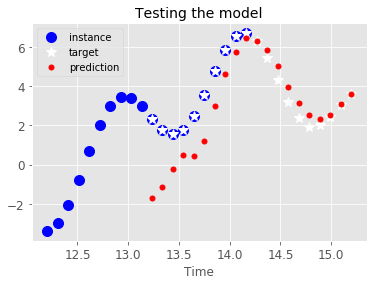

In [132]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-offset], time_series(t_instance[:-offset]), "bo", markersize=10, label="instance")
plt.plot(t_instance[offset:], time_series(t_instance[offset:]), "w*", markersize=10, label="target")
plt.plot(t_instance[offset:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

# save_fig("time_series_pred_plot")
plt.show()

## Problem 4

In [133]:
import pandas as pd
weather = pd.read_csv('jena_climate_2009_2016.csv',sep=',', header = 0, parse_dates = [1])
w0 = weather[['Date Time','T (degC)']]
w1=w0[w0['Date Time'].str.contains("01.2009")].iloc[::6, :]['T (degC)']# every 6th sample i.e once an hour
w2=w1.as_matrix(columns=None)
w3=w2/np.linalg.norm(w2, ord=np.inf, axis=0, keepdims=True)
#w3=w2
t_min, t_max = 0, 30
resolution = 1
offset=2
def time_series(t):
    return w3[t]

def next_batch2(batch_size, n_steps):
    t0 = (np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)).astype(int)
    
    Ts = t0 + np.arange(0, n_steps + offset) * resolution
    #print(Ts)
    ys=time_series(Ts)
    return ys[:, :-offset].reshape(-1, n_steps, 1), ys[:, offset:].reshape(-1, n_steps, 1)

In [134]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [135]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [136]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [137]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [138]:
saver = tf.train.Saver()

In [139]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch2(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 0.036699746
100 	MSE: 0.000546143
200 	MSE: 0.00043517243
300 	MSE: 0.0003739843
400 	MSE: 0.00036545866
500 	MSE: 0.00034523063
600 	MSE: 0.00030484927
700 	MSE: 0.0002947979
800 	MSE: 0.00026151302
900 	MSE: 0.00025312637
1000 	MSE: 0.00021964835
1100 	MSE: 0.0002150605
1200 	MSE: 0.00022242779
1300 	MSE: 0.0002158382
1400 	MSE: 0.00023521048


In [140]:
t_instance = 0 + np.arange(0, n_steps + offset) * resolution
t_instance

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [141]:

with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-offset].reshape(-offset, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [142]:
y_pred

array([[[-0.35654   ],
        [-0.34410244],
        [-0.36170748],
        [-0.38001382],
        [-0.3831694 ],
        [-0.3775821 ],
        [-0.3546749 ],
        [-0.3375875 ],
        [-0.31324434],
        [-0.32468393],
        [-0.29073638],
        [-0.25412792],
        [-0.25244364],
        [-0.24085091],
        [-0.23138347],
        [-0.23710243],
        [-0.22610226],
        [-0.21132481],
        [-0.21564934],
        [-0.20973907]]], dtype=float32)

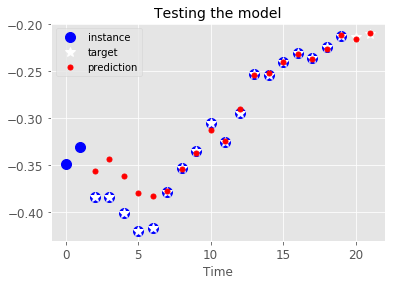

In [143]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-offset], time_series(t_instance[:-offset]), "bo", markersize=10, label="instance")
plt.plot(t_instance[offset:], time_series(t_instance[offset:]), "w*", markersize=10, label="target")
plt.plot(t_instance[offset:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

# save_fig("time_series_pred_plot")
plt.show()

## Problem 5

In [144]:
weather

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.60
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.80,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.50
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.10,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.00


In [145]:
weather.corr()

,T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
T (degC),1.000000,0.996827,0.895708,-0.572416,0.951113,0.867673,0.761744,0.866755,0.867177,-0.963410,-0.004689,-0.002871,0.038732
Tpot (K),0.996827,1.000000,0.894911,-0.567127,0.947293,0.866205,0.756962,0.866533,0.866955,-0.981345,-0.004195,-0.002224,0.043599
Tdew (degC),0.895708,0.894911,1.000000,-0.156615,0.799271,0.968344,0.435752,0.967599,0.968044,-0.885232,-0.008718,-0.009091,0.049877
rh (%),-0.572416,-0.567127,-0.156615,1.000000,-0.615842,-0.151494,-0.843835,-0.150841,-0.150969,0.514282,-0.005020,-0.009921,-0.015912
VPmax (mbar),0.951113,0.947293,0.799271,-0.615842,1.000000,0.824865,0.875588,0.824460,0.824493,-0.901536,-0.004018,-0.002213,-0.009583
VPact (mbar),0.867673,0.866205,0.968344,-0.151494,0.824865,1.000000,0.449154,0.999851,0.999856,-0.850241,-0.009600,-0.010316,0.018418
VPdef (mbar),0.761744,0.756962,0.435752,-0.843835,0.875588,0.449154,1.000000,0.448641,0.448689,-0.698290,0.001852,0.005317,-0.030881
sh (g/kg),0.866755,0.866533,0.967599,-0.150841,0.824460,0.999851,0.448641,1.000000,0.999997,-0.853325,-0.009479,-0.010163,0.019376
H2OC (mmol/mol),0.867177,0.866955,0.968044,-0.150969,0.824493,0.999856,0.448689,0.999997,1.000000,-0.853769,-0.009477,-0.010158,0.019607
rho (g/m**3),-0.963410,-0.981345,-0.885232,0.514282,-0.901536,-0.850241,-0.698290,-0.853325,-0.853769,1.000000,0.003240,0.001086,-0.058072


In [146]:
w0=weather[weather['Date Time'].str.contains("01.2009")].iloc[::6, ]# every 6th sample i.e once an hour
w2=w0.iloc[:,2:].as_matrix(columns=None)

In [147]:
w0.corr()

,T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
T (degC),1.000000,0.991608,0.943817,-0.218231,0.969099,0.915362,0.550919,0.914595,0.914714,-0.949408,0.361635,0.360091,-0.007579
Tpot (K),0.991608,1.000000,0.935326,-0.219521,0.977748,0.921854,0.558999,0.925613,0.925695,-0.981887,0.398660,0.398250,0.022826
Tdew (degC),0.943817,0.935326,1.000000,0.114641,0.889288,0.975798,0.254259,0.971403,0.971549,-0.899701,0.279612,0.280162,-0.097357
rh (%),-0.218231,-0.219521,0.114641,1.000000,-0.287382,0.124545,-0.896025,0.113454,0.113546,0.199910,-0.276242,-0.272616,-0.270784
VPmax (mbar),0.969099,0.977748,0.889288,-0.287382,1.000000,0.908641,0.634987,0.913125,0.913119,-0.955859,0.400483,0.400626,0.052167
VPact (mbar),0.915362,0.921854,0.975798,0.124545,0.908641,1.000000,0.254398,0.999276,0.999291,-0.905659,0.298450,0.301473,-0.073381
VPdef (mbar),0.550919,0.558999,0.254259,-0.896025,0.634987,0.254398,1.000000,0.266135,0.266093,-0.538352,0.375639,0.370347,0.256524
sh (g/kg),0.914595,0.925613,0.971403,0.113454,0.913125,0.999276,0.266135,1.000000,0.999993,-0.915610,0.312544,0.315901,-0.061272
H2OC (mmol/mol),0.914714,0.925695,0.971549,0.113546,0.913119,0.999291,0.266093,0.999993,1.000000,-0.915647,0.312351,0.315702,-0.061345
rho (g/m**3),-0.949408,-0.981887,-0.899701,0.199910,-0.955859,-0.905659,-0.538352,-0.915610,-0.915647,1.000000,-0.435435,-0.436636,-0.060337


In [148]:
import numpy as np
w3=w2/np.linalg.norm(w2, ord=np.inf, axis=0, keepdims=True)

In [149]:
wT=w3[:,0]
wTpot=w3[:,1]
wrho=w3[:,9]
print(len(wT))

744


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97c964d080>,
      dtype=object)

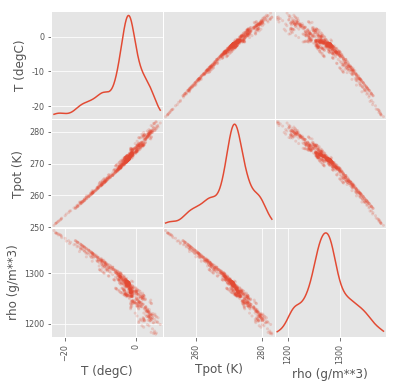

In [150]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
scatter_matrix(w0[['T (degC)', 'Tpot (K)', 'rho (g/m**3)']], alpha=0.2, figsize=(6, 6), diagonal='kde')

In [151]:
w0

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
12,01.01.2009 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.30
18,01.01.2009 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.30
24,01.01.2009 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.90
30,01.01.2009 05:10:00,997.43,-9.67,263.68,-10.63,92.6,2.93,2.71,0.22,1.69,2.72,1317.35,0.36,0.75,132.50
36,01.01.2009 06:10:00,997.81,-9.59,263.74,-10.47,93.2,2.95,2.74,0.20,1.71,2.75,1317.44,0.24,0.75,161.60
42,01.01.2009 07:10:00,998.50,-8.71,264.56,-9.63,93.0,3.16,2.94,0.22,1.83,2.94,1313.87,2.06,2.75,338.10
48,01.01.2009 08:10:00,999.27,-8.14,265.08,-9.12,92.6,3.30,3.06,0.24,1.91,3.06,1311.98,0.71,1.00,241.40
54,01.01.2009 09:10:00,999.79,-7.71,265.47,-8.87,91.3,3.41,3.12,0.30,1.94,3.12,1310.51,0.14,0.50,235.00


In [152]:
weather

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.60
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.80,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.50
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.10,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.00


In [339]:
import pandas as pd
import numpy as np
t_min, t_max = 0, 30
resolution = 1
offset=1
def time_series(t):


    ys1=np.c_[wT.reshape(-1,1), wrho.reshape(-1,1)] #select wrho or wT as input
    ys2=wT.reshape(-1,1)
    #print(t)
    return ys1[t],ys2[t]
    
    #print(ys2)
    
    
    #return ys1[:,0:40].reshape(-1,20,2), ys2[:,0:20].reshape(-1,20,1)
    
   

def next_batch3(batch_size, n_steps):
    t0 = (np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)).astype(int)
    Ts = t0 + np.arange(0, n_steps + offset-1) * resolution
    ys1,ys2=time_series(Ts)
    return ys1,ys2
   

In [341]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, 2*n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [342]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [343]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [344]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [345]:
saver = tf.train.Saver()

In [346]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch3(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 0.047954973
100 	MSE: 0.00029632903
200 	MSE: 0.0002512087
300 	MSE: 0.0001799503
400 	MSE: 0.0001408443
500 	MSE: 0.00012742175
600 	MSE: 9.6385e-05
700 	MSE: 8.1623526e-05
800 	MSE: 6.151076e-05
900 	MSE: 5.158721e-05
1000 	MSE: 4.0536288e-05
1100 	MSE: 3.4604975e-05
1200 	MSE: 2.780654e-05
1300 	MSE: 2.3275632e-05
1400 	MSE: 1.7871263e-05


In [347]:
t_instance = 0 + np.arange(0, n_steps + offset) * resolution
t_instance

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [348]:
X_new,_=time_series(t_instance[:-offset])

In [349]:
X_new.reshape(-1,20,2)
X_new.shape

(20, 2)

In [350]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    #X_new,_= time_series(np.array(t_instance[:-offset].reshape(-offset, n_steps, 1*n_inputs)))
    X_new, y_batch = next_batch3(batch_size, n_steps)
   # X_new,_= time_series(np.array(t_instance[:-offset]))
    X_new.reshape(-1,20,2)

    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [351]:
y_pred

array([[[-0.35713032],
        [-0.3342363 ],
        [-0.37392282],
        [-0.38390487],
        [-0.3965459 ],
        [-0.4139107 ],
        [-0.41335964],
        [-0.37934348],
        [-0.3540969 ],
        [-0.33226532],
        [-0.3092458 ],
        [-0.32196915],
        [-0.29749373],
        [-0.25215316],
        [-0.25548822],
        [-0.2397064 ],
        [-0.23080868],
        [-0.23666759],
        [-0.22221622],
        [-0.21323264]],

       [[-0.34777042],
        [-0.3115069 ],
        [-0.3255989 ],
        [-0.30082768],
        [-0.25761858],
        [-0.25310075],
        [-0.23983611],
        [-0.22993621],
        [-0.23466049],
        [-0.22436781],
        [-0.2129582 ],
        [-0.21586908],
        [-0.21093252],
        [-0.19583377],
        [-0.19605172],
        [-0.19966511],
        [-0.19117522],
        [-0.18655153],
        [-0.19315712],
        [-0.19824125]],

       [[-0.4082155 ],
        [-0.41811588],
        [-0.38188446],
       

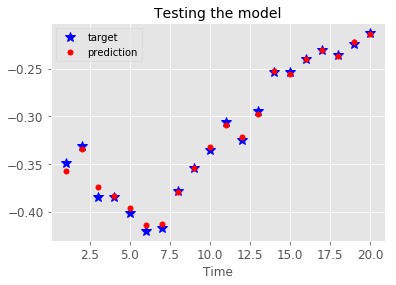

In [352]:
plt.title("Testing the model", fontsize=14)
#plt.plot(t_instance[:-offset], y_new.reshape(20,1), "bo", markersize=10, label="instance")
plt.plot(t_instance[offset:], y_new.reshape(20,1), "b*", markersize=10, label="target")
plt.plot(t_instance[offset:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

# save_fig("time_series_pred_plot")
plt.show()